In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
class MakeClass(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        uniques = torch.unique(x, sorted = True)
        for i, v in enumerate(uniques):
            x[x == v] = i
        return x.to(dtype=torch.long)

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(), 
        MakeClass()
    ]
)

train_ds = OxfordIIITPet(
    root = "~/data", split = "trainval", mode = "fine", target_types = "semantic", transform = transform, 
    target_transform = target_transform, 
    download = True
)

test_ds = OxfordIIITPet(
    root = "~/data", split = "test", mode = "fine", target_types = "semantic", transform = transform, 
    target_transform = target_transform, 
    download = True
)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory = True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(train_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

#Training Samples: 3680
#Testing Samples: 3669
#Training Batch: 58
#Testing Batch: 58


In [4]:
sample_data, sample_mask = train_ds[100]

print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")

print(f"Number classes: {np.unique(sample_mask.numpy())}")

data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([1, 256, 256])
Number classes: [0 1 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


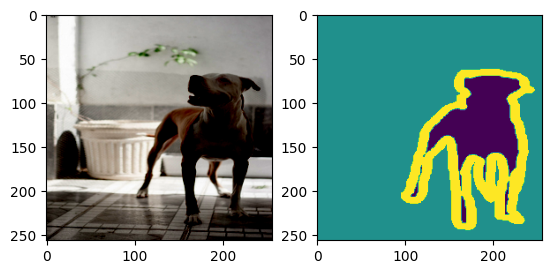

In [5]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(sample_data.cpu().permute(1, -1, 0).numpy())
axarr[1].imshow(sample_mask.cpu().permute(1, -1, 0).numpy())

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [7]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [8]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [9]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [10]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor)) #512, 1024
        self.up1 = (Up(512, 256 // factor, bilinear)) #1024, 512
        self.up2 = (Up(256, 128 // factor, bilinear)) #512, 256
        self.up3 = (Up(128, 64 // factor, bilinear)) #256, 128
        self.up4 = (Up(64, 32, bilinear)) #128, 64
        self.outc = (OutConv(32, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [11]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 1)

model = UNet(3, 3, True).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.CrossEntropyLoss()

In [13]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device, dtype = torch.long)

        train_gen_mask = model(train_img)
        train_rec_loss = loss_fn(train_gen_mask, train_mask.squeeze(1))
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            F.one_hot(train_mask.squeeze(1), 3).permute(0, 3, 1, 2).float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(test_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device, dtype = torch.long)
            
            valid_gen_mask = model(valid_img)
            valid_rec_loss = loss_fn(valid_gen_mask, valid_mask.squeeze(1))
            valid_dice_loss = dice_loss(
                F.softmax(valid_gen_mask, dim=1).float(),
                F.one_hot(valid_mask.squeeze(1), 3).permute(0, 3, 1, 2).float(),
                multiclass=True
            )
            valid_loss = valid_rec_loss + valid_dice_loss

            va_total_loss += valid_loss.item()
            
    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(test_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")
model.load_state_dict(best_dct)

100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.13it/s]


Epoch: 0 - TrainLoss: 1.1984290439507057 - ValidLoss: 0.9762952327728271


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.10it/s]


Epoch: 1 - TrainLoss: 0.8807086533513563 - ValidLoss: 0.8539214730262756


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.17it/s]


Epoch: 2 - TrainLoss: 0.7445169224821288 - ValidLoss: 0.7049385905265808


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.20it/s]


Epoch: 3 - TrainLoss: 0.6647198909315569 - ValidLoss: 0.6559193134307861


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.18it/s]


Epoch: 4 - TrainLoss: 0.6101985409342009 - ValidLoss: 0.6147163510322571


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.25it/s]


Epoch: 5 - TrainLoss: 0.5620003846184961 - ValidLoss: 0.5901257991790771


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.15it/s]


Epoch: 6 - TrainLoss: 0.5287854748553243 - ValidLoss: 0.48156410455703735


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.05it/s]


Epoch: 7 - TrainLoss: 0.49455480688604814 - ValidLoss: 0.480418860912323


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.00it/s]


Epoch: 8 - TrainLoss: 0.47440782600435716 - ValidLoss: 0.47972366213798523


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.04it/s]


Epoch: 9 - TrainLoss: 0.479255739471008 - ValidLoss: 0.745468258857727


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.10it/s]


Epoch: 10 - TrainLoss: 0.45340714526587517 - ValidLoss: 0.3634566366672516


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.22it/s]


Epoch: 11 - TrainLoss: 0.4273904654486426 - ValidLoss: 0.42722851037979126


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.08it/s]


Epoch: 12 - TrainLoss: 0.4191107523852381 - ValidLoss: 0.37779390811920166


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.11it/s]


Epoch: 13 - TrainLoss: 0.406600943413274 - ValidLoss: 0.37014663219451904


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.05it/s]


Epoch: 14 - TrainLoss: 0.38775445263961267 - ValidLoss: 0.3804967403411865


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.16it/s]


Epoch: 15 - TrainLoss: 0.37623467065137006 - ValidLoss: 0.3729839324951172


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.07it/s]


Epoch: 16 - TrainLoss: 0.35615284740924835 - ValidLoss: 0.35282811522483826


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.08it/s]


Epoch: 17 - TrainLoss: 0.34722135961055756 - ValidLoss: 0.35633379220962524


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.13it/s]


Epoch: 18 - TrainLoss: 0.34729957580566406 - ValidLoss: 0.28964370489120483


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.12it/s]


Epoch: 19 - TrainLoss: 0.3355123169463256 - ValidLoss: 0.334041953086853


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.13it/s]


Epoch: 20 - TrainLoss: 0.3088178028320444 - ValidLoss: 0.2706250548362732


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.04it/s]


Epoch: 21 - TrainLoss: 0.3095788452131995 - ValidLoss: 0.2890157103538513


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.18it/s]


Epoch: 22 - TrainLoss: 0.29785595782871904 - ValidLoss: 0.27982309460639954


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.07it/s]


Epoch: 23 - TrainLoss: 0.2931908818668333 - ValidLoss: 0.2808707058429718


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.14it/s]


Epoch: 24 - TrainLoss: 0.27616093564650107 - ValidLoss: 0.30059438943862915


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.99it/s]


Epoch: 25 - TrainLoss: 0.2650376632809639 - ValidLoss: 0.2777552604675293


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.09it/s]


Epoch: 26 - TrainLoss: 0.263702555977065 - ValidLoss: 0.28799617290496826


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.22it/s]


Epoch: 27 - TrainLoss: 0.2602567544271206 - ValidLoss: 0.21270178258419037


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.07it/s]


Epoch: 28 - TrainLoss: 0.25528005998710107 - ValidLoss: 0.2634860873222351


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.11it/s]


Epoch: 29 - TrainLoss: 0.23803963229574007 - ValidLoss: 0.2266603410243988


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.08it/s]


Epoch: 30 - TrainLoss: 0.2320571595738674 - ValidLoss: 0.2129281908273697


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.04it/s]


Epoch: 31 - TrainLoss: 0.22376564864454598 - ValidLoss: 0.22601506114006042


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.16it/s]


Epoch: 32 - TrainLoss: 0.21694732971232514 - ValidLoss: 0.2095416784286499


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.09it/s]


Epoch: 33 - TrainLoss: 0.21513100302424923 - ValidLoss: 0.23158380389213562


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.15it/s]


Epoch: 34 - TrainLoss: 0.22024403692319475 - ValidLoss: 0.2402457296848297


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.16it/s]


Epoch: 35 - TrainLoss: 0.21129529923200607 - ValidLoss: 0.23736853897571564


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.07it/s]


Epoch: 36 - TrainLoss: 0.19928366228424269 - ValidLoss: 0.18636438250541687


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.01it/s]


Epoch: 37 - TrainLoss: 0.19289852961384016 - ValidLoss: 0.18174082040786743


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.17it/s]


Epoch: 38 - TrainLoss: 0.18735998946017232 - ValidLoss: 0.17797106504440308


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.11it/s]


Epoch: 39 - TrainLoss: 0.20711909491440345 - ValidLoss: 0.1937674880027771


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.14it/s]


Epoch: 40 - TrainLoss: 0.18668574839830399 - ValidLoss: 0.16835559904575348


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.17it/s]


Epoch: 41 - TrainLoss: 0.1808685185066585 - ValidLoss: 0.21939709782600403


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.17it/s]


Epoch: 42 - TrainLoss: 0.17592077239834028 - ValidLoss: 0.18437740206718445


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.13it/s]


Epoch: 43 - TrainLoss: 0.1674609068652679 - ValidLoss: 0.2130620777606964


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.16it/s]


Epoch: 44 - TrainLoss: 0.1664662839009844 - ValidLoss: 0.18059778213500977


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.12it/s]


Epoch: 45 - TrainLoss: 0.16501703601458978 - ValidLoss: 0.15791761875152588


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.10it/s]


Epoch: 46 - TrainLoss: 0.1575305813859249 - ValidLoss: 0.1578660011291504


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.17it/s]


Epoch: 47 - TrainLoss: 0.15508578024033842 - ValidLoss: 0.15817120671272278


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.08it/s]


Epoch: 48 - TrainLoss: 0.15446364057475123 - ValidLoss: 0.14974012970924377


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.16it/s]


Epoch: 49 - TrainLoss: 0.14971329605784908 - ValidLoss: 0.14205415546894073


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.26it/s]


Epoch: 50 - TrainLoss: 0.1480602059384872 - ValidLoss: 0.16065305471420288


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.08it/s]


Epoch: 51 - TrainLoss: 0.14365007214505096 - ValidLoss: 0.14942693710327148


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.09it/s]


Epoch: 52 - TrainLoss: 0.13976989712180762 - ValidLoss: 0.14347493648529053


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.17it/s]


Epoch: 53 - TrainLoss: 0.13511980710358457 - ValidLoss: 0.1346854716539383


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.18it/s]


Epoch: 54 - TrainLoss: 0.13126669798431725 - ValidLoss: 0.13471052050590515


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.07it/s]


Epoch: 55 - TrainLoss: 0.1293581864186402 - ValidLoss: 0.13814449310302734


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.21it/s]


Epoch: 56 - TrainLoss: 0.12797610551632685 - ValidLoss: 0.1317150890827179


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.29it/s]


Epoch: 57 - TrainLoss: 0.12576660706565299 - ValidLoss: 0.13397976756095886


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.03it/s]


Epoch: 58 - TrainLoss: 0.1236685870279526 - ValidLoss: 0.12645530700683594


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.14it/s]


Epoch: 59 - TrainLoss: 0.12424225475767563 - ValidLoss: 0.12463288009166718


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.16it/s]


Epoch: 60 - TrainLoss: 0.11846295962559766 - ValidLoss: 0.11788440495729446


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.04it/s]


Epoch: 61 - TrainLoss: 0.11512231762553084 - ValidLoss: 0.11920872330665588


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.12it/s]


Epoch: 62 - TrainLoss: 0.11278338293577063 - ValidLoss: 0.12009680271148682


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.05it/s]


Epoch: 63 - TrainLoss: 0.11067602680674915 - ValidLoss: 0.1120620146393776


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.11it/s]


Epoch: 64 - TrainLoss: 0.10962056779655917 - ValidLoss: 0.11504042148590088


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.09it/s]


Epoch: 65 - TrainLoss: 0.10712698500218062 - ValidLoss: 0.11081141978502274


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.21it/s]


Epoch: 66 - TrainLoss: 0.1059302403752146 - ValidLoss: 0.10132599622011185


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.09it/s]


Epoch: 67 - TrainLoss: 0.10392365668868196 - ValidLoss: 0.10878518223762512


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.09it/s]


Epoch: 68 - TrainLoss: 0.10182659906046145 - ValidLoss: 0.10541881620883942


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.13it/s]


Epoch: 69 - TrainLoss: 0.10192519285041711 - ValidLoss: 0.10898249596357346


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.12it/s]


Epoch: 70 - TrainLoss: 0.09903524751807082 - ValidLoss: 0.10069572925567627


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.21it/s]


Epoch: 71 - TrainLoss: 0.09693642538683168 - ValidLoss: 0.09819307178258896


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.14it/s]


Epoch: 72 - TrainLoss: 0.09543642966911711 - ValidLoss: 0.09669369459152222


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.06it/s]


Epoch: 73 - TrainLoss: 0.09412217936639128 - ValidLoss: 0.08566251397132874


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.14it/s]


Epoch: 74 - TrainLoss: 0.09312988175400372 - ValidLoss: 0.09920574724674225


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.16it/s]


Epoch: 75 - TrainLoss: 0.09156759661333315 - ValidLoss: 0.09734927862882614


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.10it/s]


Epoch: 76 - TrainLoss: 0.09030312762178223 - ValidLoss: 0.0921509861946106


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.29it/s]


Epoch: 77 - TrainLoss: 0.08926405487903233 - ValidLoss: 0.0996895283460617


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.12it/s]


Epoch: 78 - TrainLoss: 0.08799958730052257 - ValidLoss: 0.09333616495132446


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.35it/s]


Epoch: 79 - TrainLoss: 0.08728078945443549 - ValidLoss: 0.08310441672801971


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.14it/s]


Epoch: 80 - TrainLoss: 0.08679697290062904 - ValidLoss: 0.09614534676074982


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.10it/s]


Epoch: 81 - TrainLoss: 0.08614272328800168 - ValidLoss: 0.08705759048461914


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.12it/s]


Epoch: 82 - TrainLoss: 0.08514718724222019 - ValidLoss: 0.08994577080011368


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.19it/s]


Epoch: 83 - TrainLoss: 0.08481704584997275 - ValidLoss: 0.08548645675182343


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.21it/s]


Epoch: 84 - TrainLoss: 0.08433120196749425 - ValidLoss: 0.09867331385612488


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.03it/s]


Epoch: 85 - TrainLoss: 0.08303884892114277 - ValidLoss: 0.09000943601131439


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.17it/s]


Epoch: 86 - TrainLoss: 0.08273818331031964 - ValidLoss: 0.08784568309783936


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.02it/s]


Epoch: 87 - TrainLoss: 0.08289945870637894 - ValidLoss: 0.10103487968444824


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.99it/s]


Epoch: 88 - TrainLoss: 0.08158188672928975 - ValidLoss: 0.08537607640028


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.09it/s]


Epoch: 89 - TrainLoss: 0.08142997607074935 - ValidLoss: 0.09276381134986877


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.00it/s]


Epoch: 90 - TrainLoss: 0.08141630027314713 - ValidLoss: 0.08689841628074646


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.09it/s]


Epoch: 91 - TrainLoss: 0.08076200364478703 - ValidLoss: 0.09103886038064957


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.12it/s]


Epoch: 92 - TrainLoss: 0.08045048574949133 - ValidLoss: 0.08633838593959808


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.03it/s]


Epoch: 93 - TrainLoss: 0.08037361245730827 - ValidLoss: 0.08604715019464493


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.02it/s]


Epoch: 94 - TrainLoss: 0.0800725853648679 - ValidLoss: 0.08499343693256378


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.02it/s]


Epoch: 95 - TrainLoss: 0.08037141646290648 - ValidLoss: 0.08850176632404327


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.08it/s]


Epoch: 96 - TrainLoss: 0.07990540037381239 - ValidLoss: 0.09162144362926483


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.20it/s]


Epoch: 97 - TrainLoss: 0.07970962416509102 - ValidLoss: 0.07744207978248596


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.24it/s]


Epoch: 98 - TrainLoss: 0.07939391313441868 - ValidLoss: 0.0790049135684967


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.06it/s]

Epoch: 99 - TrainLoss: 0.07978968823264385 - ValidLoss: 0.07960061728954315


<All keys matched successfully>

In [ ]:
model.eval()
with torch.no_grad():
    ts_total_loss = 0
    for test_img, test_mask in tqdm(test_dl):
        test_img = test_img.to(device)
        test_mask = test_mask.to(device)
        
        test_gen_mask = model(test_img)
        test_rec_loss = loss_fn(test_gen_mask, test_mask)
        test_dice_loss = dice_loss(
            F.softmax(test_gen_mask, dim=1).float(),
            test_mask.float(),
            multiclass=True
        )
        test_loss = test_rec_loss + test_dice_loss

        ts_total_loss += test_loss.cpu().item()
mean_test_loss = ts_total_loss/len(test_dl)
print(f"TestLoss: {mean_test_loss}")

  0%|                                                                               | 0/10 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 10%|███████                                                                | 1/10 [00:00<00:00,  9.95it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 30%|█████████████████████▎                                                 | 3/10 [00:00<00:00,  9.80it/s]Clipping input data

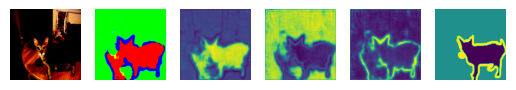

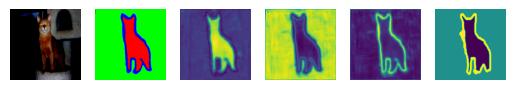

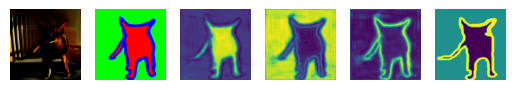

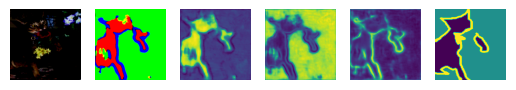

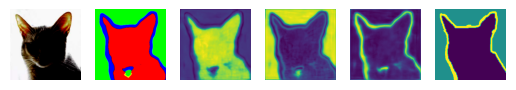

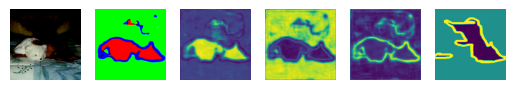

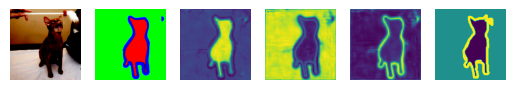

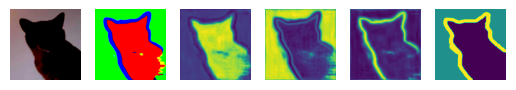

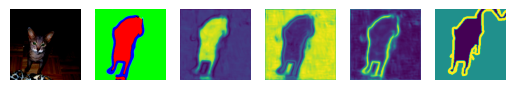

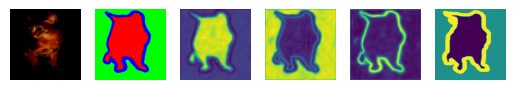

In [14]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        valid_img, valid_mask = test_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     
        # f, axarr = plt.subplots(1, total_num_class + 3, figsize = (20,15))
        f, axarr = plt.subplots(1, 2, figsize = (20,15))
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(torch.argmax(gen_mask[0], dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        # for idx in range(total_num_class):
        #     axarr[idx + 2].imshow(gen_mask[0][idx].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        #     axarr[idx + 2].axis('off')
        # axarr[total_num_class+2].imshow(torch.argmax(valid_mask, dim=0).unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        # axarr[total_num_class+2].axis('off')